In [19]:
#By: Alexis Pacek
#Date: Octubre de 2021



#Importo las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy import stats
from scipy.stats import norm
from prophet import Prophet

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [20,9]


In [7]:
#importo el data set de las ventas de krostyburgers



df = pd.read_csv('Argetina-2019-anonimizado.csv', parse_dates=[['Fecha', 'Hora']])  
df = df.set_index(['Fecha_Hora'])

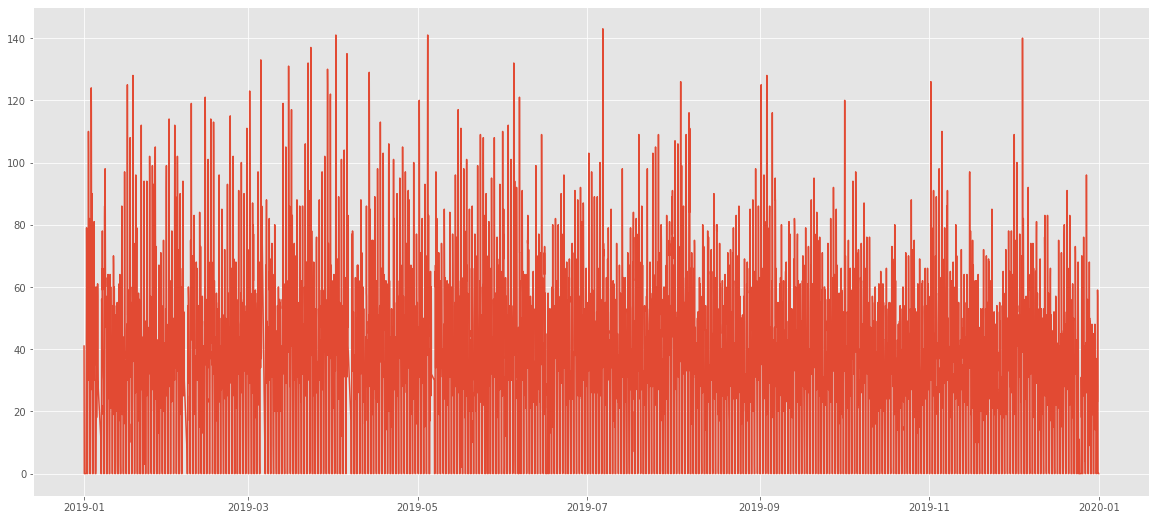

In [3]:

df1 = df.loc[df['Area']==6]
x = df1.loc[df1['Local']==1].sort_index()
plt.plot(x['Ventas'])

In [6]:
"""ejemplo de mascara"""
#mask = (df.index >= '2019-01-01 06:00:00') & (df.index <= '2019-01-01 19:00:00') & (df.Area == 6) 

#df[mask]

'ejemplo de mascara'

In [4]:
from statsmodels.graphics import tsaplots


#plot autocorrelation function
fig = tsaplots.plot_acf(x['Ventas'], lags=100)
plt.show()

In [63]:
mf1 = df['Local']==1
mf2 = df['Area'] == 9

df1 = df.loc[mf1 & mf2]
#df1.loc['2019-1-1' : '2019-1-2']
#df.loc[mf1 & mf2 & mf3]
a = df1.loc['2019-1-1' : '2019-1-1 2300'].sort_index()


In [64]:
plt.plot(a['Ventas'])
plt.xticks(rotation = 45);

# Exploración inicial

###  ¿La tabla posee valores nulos?

In [4]:
string_vacio = df.applymap(lambda x: x == '').sum().sum() #Busco entradas con strings vacios ('')
nan_y_none = df.isnull().sum().sum() #Busco NaN's y None's
print('Hay %d valores nulos en la tabla.' % (string_vacio+nan_y_none)) #sumo los 3 tipos y los printeo

Hay 0 valores nulos en la tabla.


### ¿Cuántos locales posee la empresa?

In [5]:
"""
cuento la cantidad de elementos que hay en un array conformado por 
los id's de los locales sin repetir.
"""
total_locales = len(df['Local'].unique()) 

print('Hay' , total_locales, 'locales.') 


Hay 232 locales.


### ¿Cuántos tipos de locales hay? ¿Cuántos locales hay por cada tipo?

In [6]:
"""

De cada entrada tomo la información del tipo de local, luego me quedo con los elementos
que no se repiten. Printeo cuantos elementos no se repiten y cuales son ellos.

"""

cantidad_de_locales = len(df['Tipo_Local'].unique())

print('Hay', cantidad_de_locales,'tipos de locales.\n Ellos son:')

for i in df['Tipo_Local'].unique():
    print('-',i)


Hay 4 tipos de locales.
 Ellos son:
- IS
- FC
- FS
- MS


In [7]:
"""
Corroboro que cada local solo este clasificado como un único tipo de local.

"""

aux = []
for i in df.Local.unique():
    if len(df[df.Local==i]['Tipo_Local'].unique()) >=2:
        aux.append(len(df[df.Local==i]['Tipo_Local'].unique()))

cantidad = len(aux)
        
print('Hay',cantidad,'entradas clasificadas como 2 tipos de locales (o más) al mismo tiempo.')    

Hay 0 entradas clasificadas como 2 tipos de locales (o más) al mismo tiempo.


In [8]:
"""
Como cada local solo esta caracterizado como uno de los 4 tipos posibles.
Filtro todas las entradas en donde se repite el número de local y cuento 
cuantos locales hay de cada tipo. Printeo el valor absoluto y el valor relativo para cada uno de 
los 4 tipos.

"""

tipos_locales = df['Tipo_Local'].unique()
todos = df.drop_duplicates(['Local'])

for i in tipos_locales:

    cantidad = todos[todos.Tipo_Local==i].shape[0]
    print(cantidad,'locales son', i+'.', round((cantidad/total_locales)*100,2),'%')

81 locales son IS. 34.91 %
37 locales son FC. 15.95 %
65 locales son FS. 28.02 %
49 locales son MS. 21.12 %


### ¿Cuántas áreas hay? ¿Todos los locales tienen la misma cantidad de áreas? Graficar la distribución de la cantidad de áreas por local.

In [9]:
areas = df['Area'].unique()      #creo un array con las áreas posibles
cant_areas = len(areas)          #cuento cuantas areas hay
print('Hay',cant_areas,'áreas.') #printeo cant. de áreas


Hay 9 áreas.


In [10]:
#Exploro para 5 locales

j=0
for i in df['Local'].unique():
    print('Local número',i,'tiene',df[df.Local==i]['Area'].unique(),
          'áreas')
    j+=1
    if j==5:
        break

Local número 462 tiene [6 7 9] áreas
Local número 89869 tiene [5 6] áreas
Local número 89985 tiene [ 6 17  5] áreas
Local número 507 tiene [6 9 3] áreas
Local número 403 tiene [3 6] áreas


### Conclusión: distintos locales pueden tener distintas áreas.

In [11]:
"""
creo la variable "y" donde voy a appendear todas las áreas que hay para cada local

"""

y=[]
for i in df['Local'].unique():
    a = df[df.Local==i]['Area'].unique()
    for j in a:
        y.append(j)

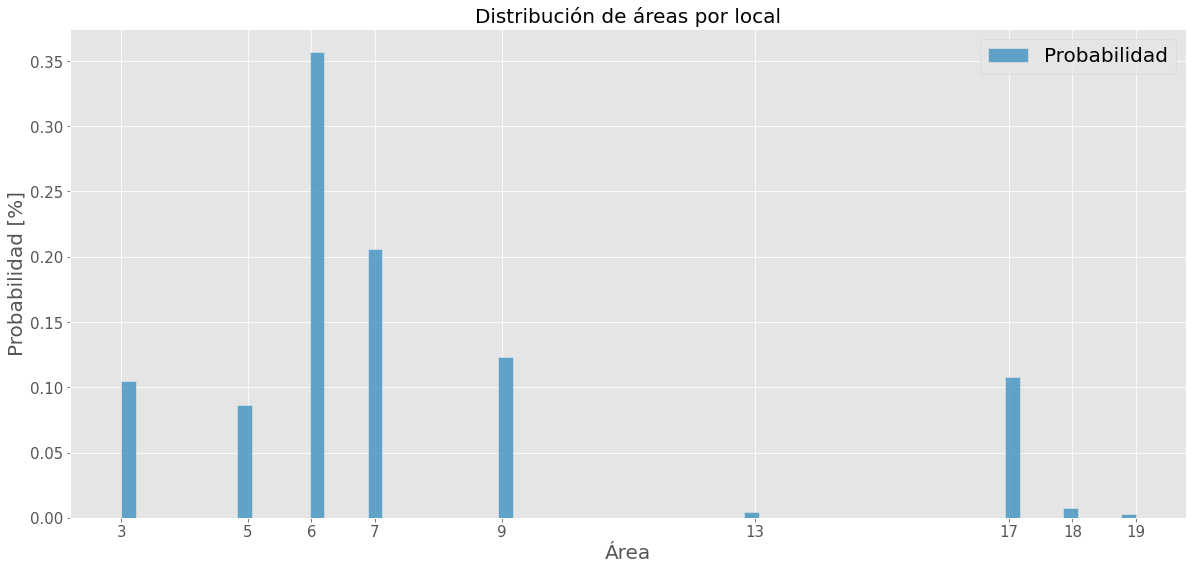

In [25]:
"""
Grafico el histograma normalizado.
"""


g = sns.histplot(y, stat='probability', label='Probabilidad')
g.set_xlabel('Área', fontsize=20)
g.set_ylabel('Probabilidad [%]',fontsize=20 )
plt.xticks(areas,fontsize=15)
plt.yticks(fontsize=15)

plt.title("Distribución de áreas por local", fontsize=20);
plt.legend(fontsize=20);


###  ¿Están correlacionadas la hora y la venta? Cuantificar esta correlación

In [13]:
hora = range(24)
total = []
for i in range(24):
    mask = (df.index.hour == i)
    total.append(round(df[mask]['Ventas'].mean()))


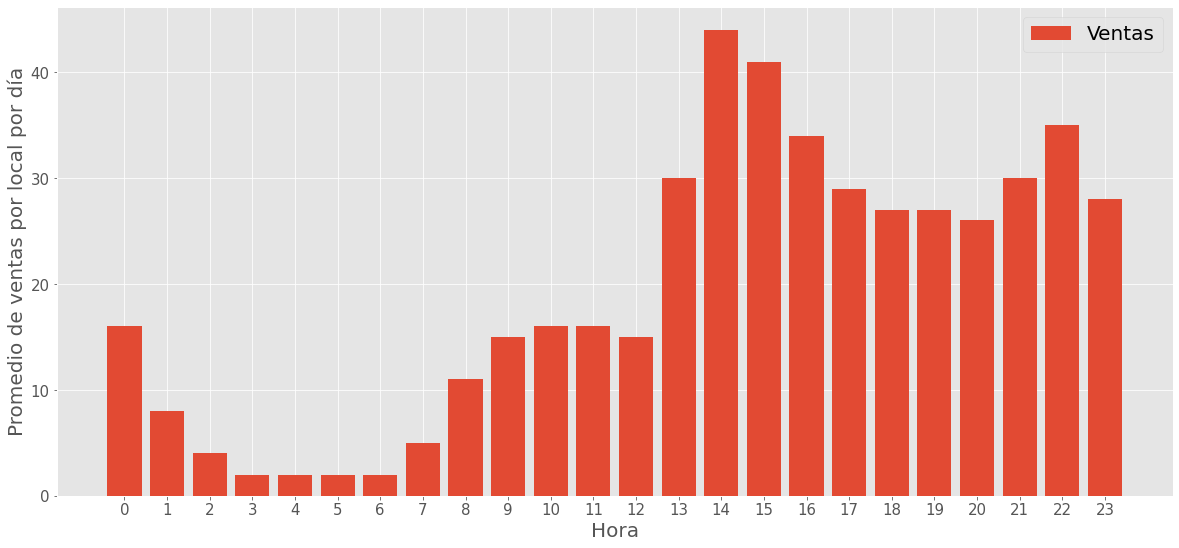

In [22]:

plt.bar(hora,total, label='Ventas')
plt.xticks(hora, fontsize=15)
plt.xlabel("Hora",fontsize= 20)
plt.ylabel('Promedio de ventas por local por día', fontsize=20)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)

# Exploración de un local particular

### Filtro el dataset y me quedo con el local 85262 y mes de junio

In [8]:
filtro = (df.Local == 85262) & (df.index.month==6)

In [9]:
df1 = df[filtro]

### Calculo la correlación entre la hora y la venta

In [28]:
hora = range(24)
total = []
for i in range(24):
    mask = (df1.index.hour == i)
    total.append(round(df1[mask]['Ventas'].mean()))

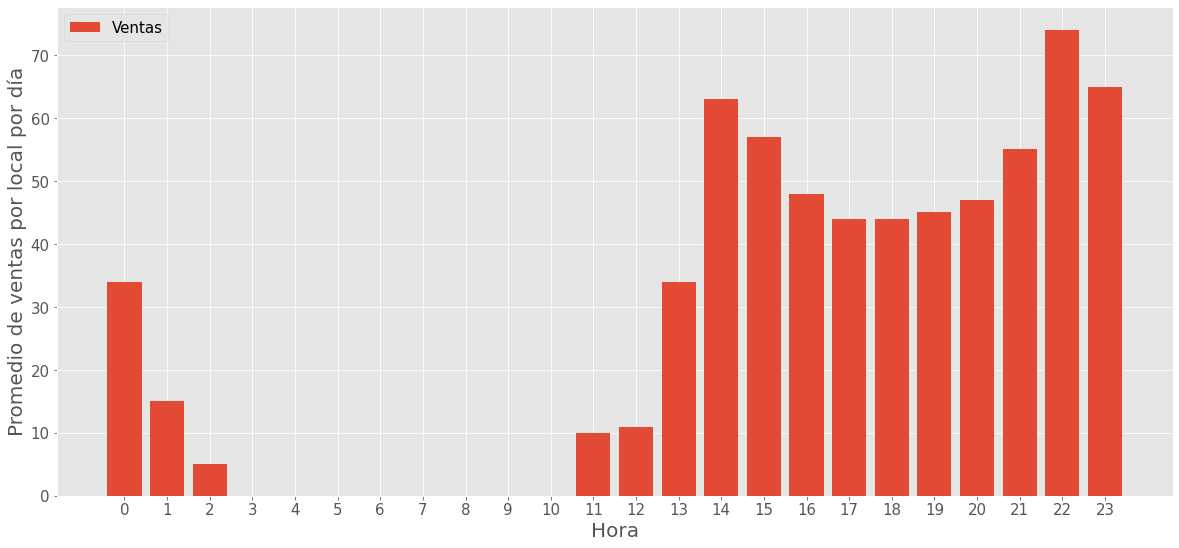

In [32]:
plt.bar(hora,total, label='Ventas')
plt.xticks(hora,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Hora", fontsize=20)
plt.ylabel('Promedio de ventas por local por día',fontsize=20)
plt.legend(fontsize=15)

### Calcular la correlación entre la hora y la venta para cada área


Text(0.5, 0.98, 'Promedio de ventas para el local 85262')

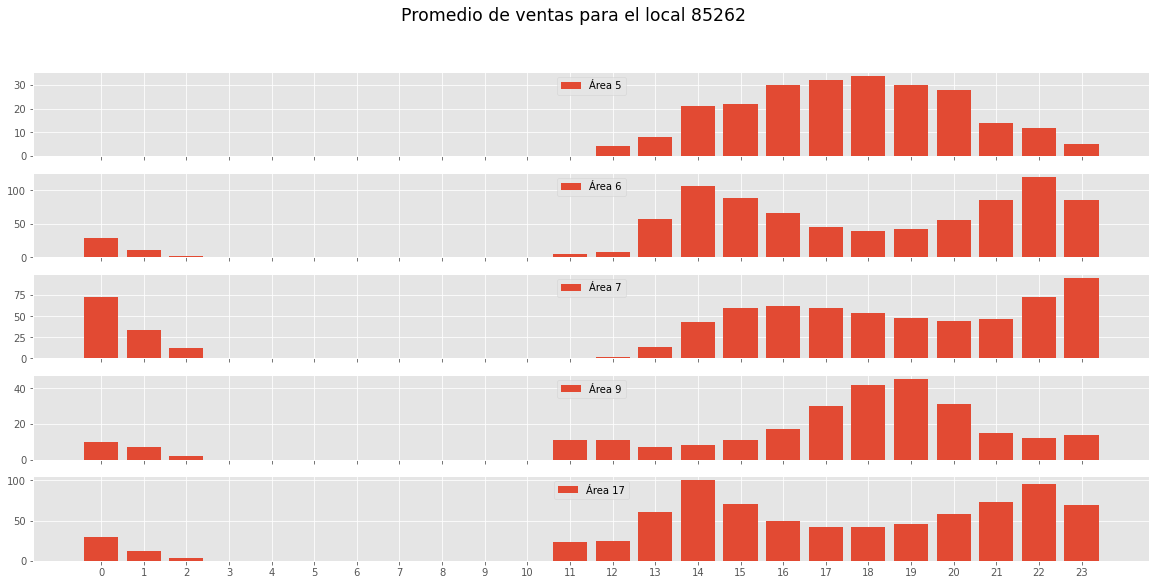

In [35]:
areas = np.sort(df1.Area.unique())
hora = range(24)

fig, axs = plt.subplots(len(areas),sharex=True)
plt.xticks(hora);
#

cont = 0
for j in areas:
    
    total = []
    for i in range(24):
        mask = (df1.index.hour == i) & (df1.Area == j)
        total.append(round(df1[mask]['Ventas'].mean()))

    #plt.figure(figsize=(10,5))
    #plt.bar(hora,total, label='Ventas para el área {}'.format(j))
    #plt.xticks(hora)
    #plt.xlabel("Hora")
    #plt.ylabel('Promedio de ventas por local por día')
    #plt.legend()
    axs[cont].bar(hora,total, label='Área {}'.format(j))
    axs[cont].legend(loc='upper center')
   
    cont += 1
fig.suptitle('Promedio de ventas para el local 85262', fontsize='xx-large')    
  


Graficar las ventas en función del tiempo para las diferentes áreas. ¿Qué estacionalidades pueden 
observarse?

<AxesSubplot:xlabel='Fecha_Hora', ylabel='Ventas'>

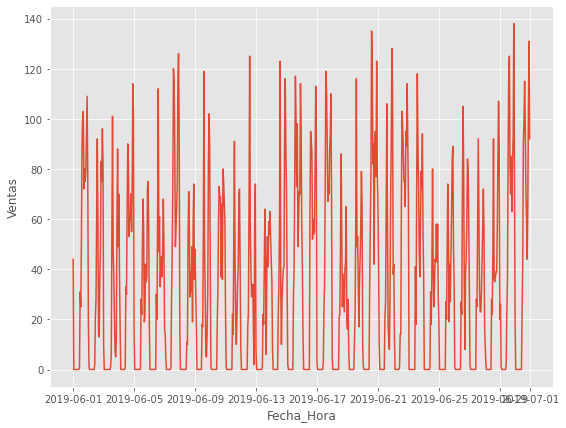

In [11]:

mask = (df1.Area == 17)
plt.figure(figsize=(9,7))
sns.lineplot(data=df1.loc[mask]['Ventas'].sort_index())

In [37]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')
stats, p, lags, critical_values = kpss(np.array(df1.loc[mask]['Ventas'].sort_index()))
print(f'Test Estadistico: {stats}')
print(f'p-valor: {p}')
print(f'critical_value: {critical_values}')

if p<0.05:
    print('La serie no es estacionaria')
else:
    print('La serie es estacionaria')

Test Estadistico: 0.2579205117636958
p-valor: 0.1
critical_value: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria


In [38]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.array(df1.loc[mask]['Ventas'].sort_index()))
print(f'test estadistico: {result[0]}')
print(f'p-valor: {result[1]}')
print(f'Critical_values: {result[4]}')

if result[1] > 0.05:
    print('La serie no es estacionaria')
else:
    print('La serie es estacionaria')


test estadistico: -5.612382923401093
p-valor: 1.1953452326872332e-06
Critical_values: {'1%': -3.439739809554328, '5%': -2.86568368980381, '10%': -2.5689766074363334}
La serie es estacionaria


In [12]:
data =  pd.DataFrame(df1.loc[mask].sort_values(by='Fecha_Hora',ascending=True)['Ventas'])
data.asfreq('H')

,Ventas
Fecha_Hora,
2019-06-01 00:00:00,44
2019-06-01 01:00:00,0
2019-06-01 02:00:00,0
2019-06-01 03:00:00,0
2019-06-01 04:00:00,0
...,...
2019-06-30 19:00:00,44
2019-06-30 20:00:00,65
2019-06-30 21:00:00,104


In [13]:
data_train = data['2019-06-01':'2019-06-21']
data_test = data['2019-06-22':'2019-06-30']

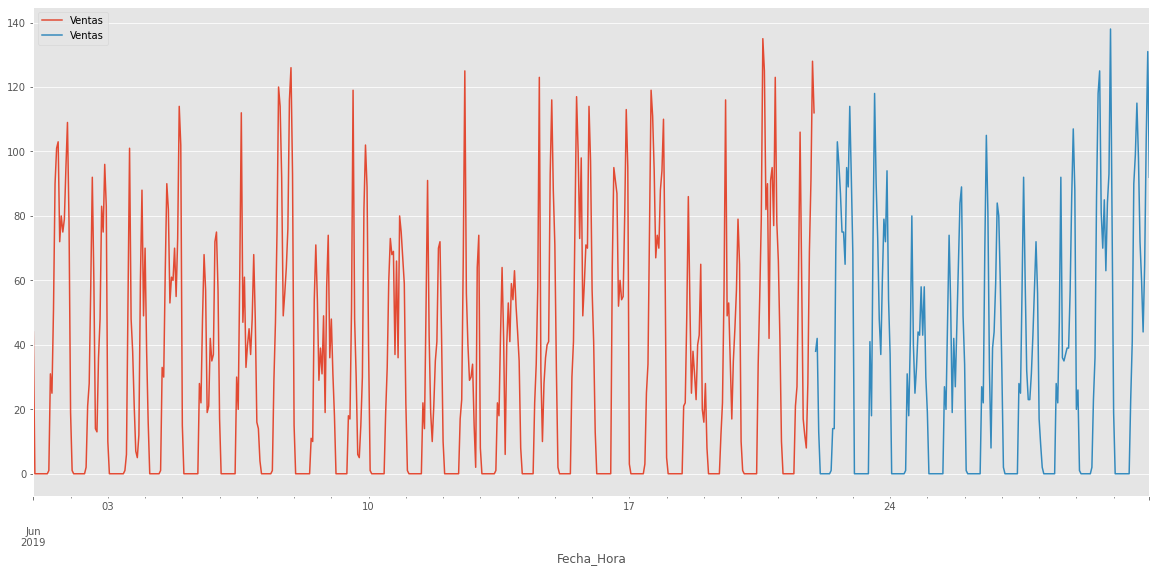

In [14]:
fig, ax=plt.subplots()
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

TypeError: 'NoneType' object is not callable

In [58]:
data.index.freq()

TypeError: 'NoneType' object is not callable

In [15]:
data_prediction = data['2019-06-1':'2019-06-21']
data_test = data['2019-06-22':'2019-06-30']

In [16]:
steps = 216
datos_train = data[:-steps]
datos_test  = data[-steps:]

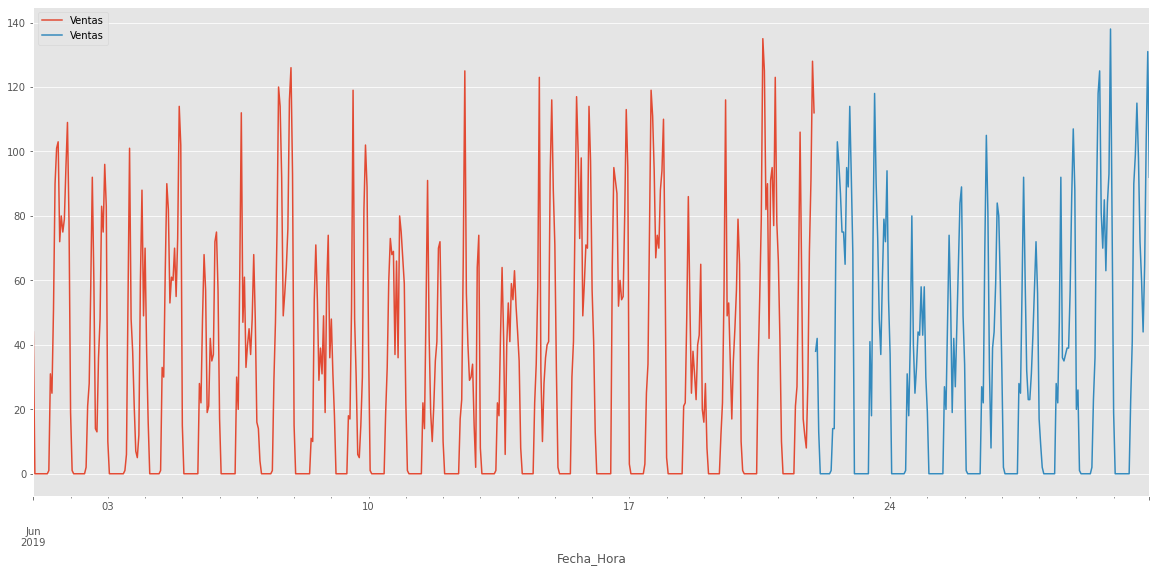

In [17]:
fig, ax=plt.subplots()
datos_train.plot(ax=ax, label="train")
datos_test.plot(ax=ax, label="tessdft")
ax.legend();

In [60]:
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(max_depth=10, n_estimators=500,random_state=123),
                    lags=100
                )

forecaster_rf.fit(y=datos_train['Ventas'])

forecaster_rf

steps = 216
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

Fecha_Hora
2019-06-22 00:00:00    52.685318
2019-06-22 01:00:00    31.471736
2019-06-22 02:00:00    14.679555
2019-06-22 03:00:00     1.336175
2019-06-22 04:00:00     0.062254
dtype: float64

In [61]:
# Predicciones
# ==============================================================================
steps = 216
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

Fecha_Hora
2019-06-22 00:00:00    52.685318
2019-06-22 01:00:00    31.471736
2019-06-22 02:00:00    14.679555
2019-06-22 03:00:00     1.336175
2019-06-22 04:00:00     0.062254
dtype: float64

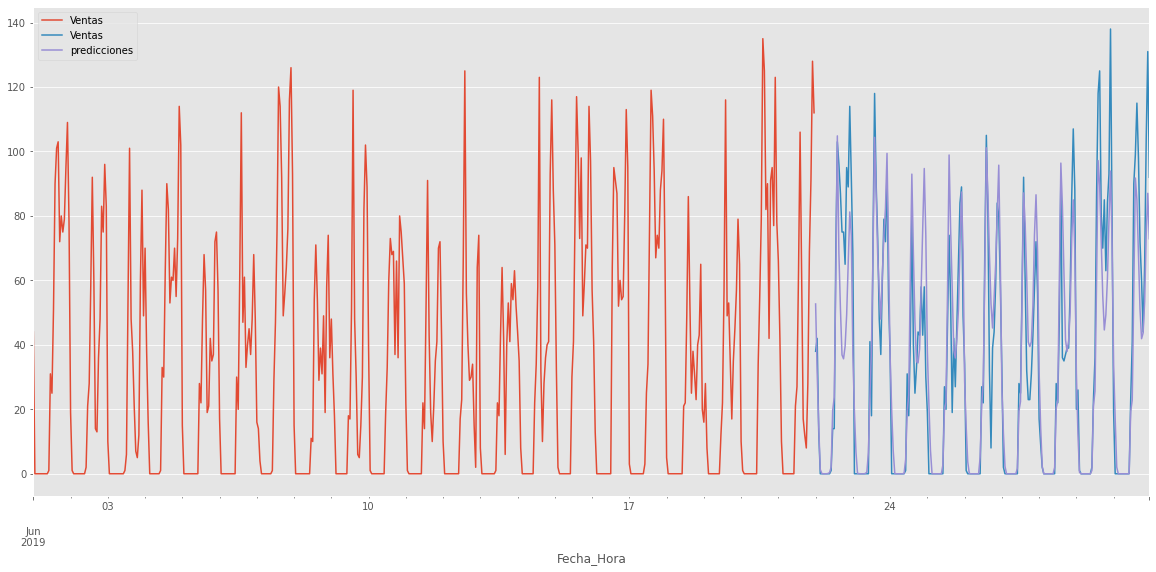

In [62]:
fig, ax = plt.subplots()
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [63]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 241.008517937614


In [52]:


aux = []

for i in tqdm(range(1,245)):
    
    forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=123),
                    lags=i
                )

    forecaster_rf.fit(y=datos_train['Ventas'])



    steps = 216
    predicciones = forecaster_rf.predict(steps=steps)
    # Se añade el índice temporal a las predicciones
    predicciones = pd.Series(data=predicciones, index=datos_test.index)
    predicciones.head()
    
    
    forecaster_rf.fit(y=datos_train['Ventas'])
    error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
    aux.append(error_mse)
    
    
   

  1%|          | 3/244 [00:24<32:36,  8.12s/it]


KeyboardInterrupt: 

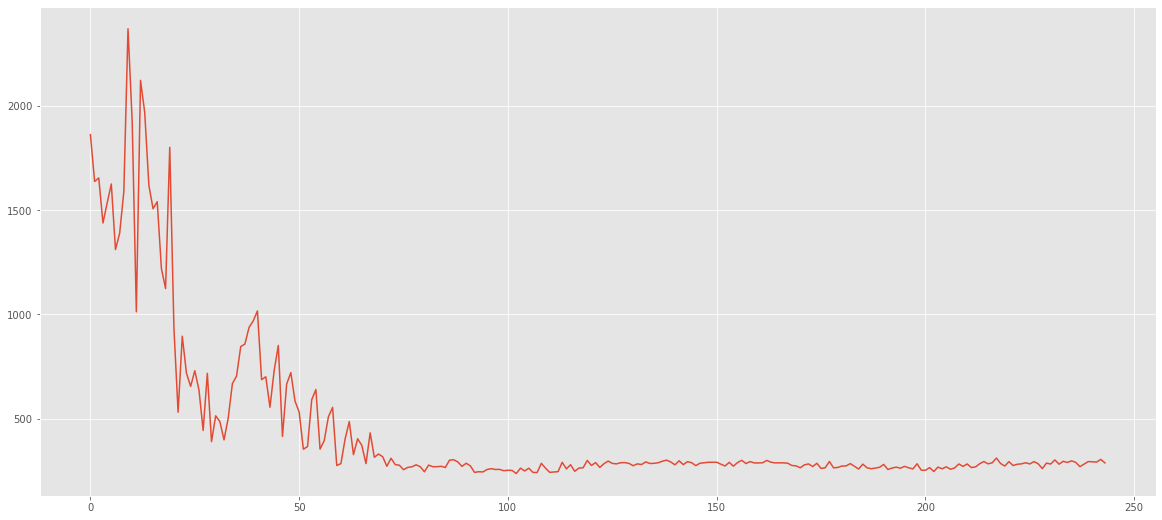

In [37]:
plt.plot(aux)

In [50]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train['Ventas'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 216,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-09-23 20:35:27,555 root       INFO  Number of models compared: 12
loop lags_grid: 100%|██████████| 2/2 [00:48<00:00, 24.04s/it] 
2021-09-23 20:36:15,638 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
params: {'max_depth': 5, 'n_estimators': 500}



In [51]:
resultados_grid

,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",322.799046,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",336.725953,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",397.804644,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",485.937093,10,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",1363.832355,10,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",1379.757983,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",1387.086585,5,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",1406.555163,3,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",1407.332737,10,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",1702.772389,3,500


In [54]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 100
                )

forecaster_rf.fit(y=datos_train['Ventas'])

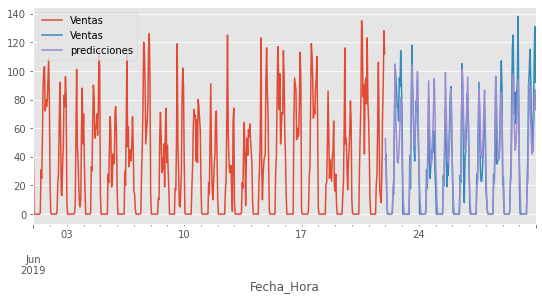

In [64]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();bar = Bar('Processing', max=20)


In [22]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [184]:
data_prediction = data_prediction.reset_index()
data_test = data_test.reset_index()

In [185]:
data_prediction.columns = ['ds', 'y']

In [186]:
data_prediction

,ds,y
0,2019-06-01 00:00:00,44
1,2019-06-01 01:00:00,0
2,2019-06-01 02:00:00,0
3,2019-06-01 03:00:00,0
4,2019-06-01 04:00:00,0
...,...,...
499,2019-06-21 19:00:00,28
500,2019-06-21 20:00:00,69
501,2019-06-21 21:00:00,91
502,2019-06-21 22:00:00,128


In [231]:
m = Prophet(changepoint_prior_scale=0.001)
m.fit(data_prediction)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [232]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
506,2019-06-24 23:00:00
507,2019-06-25 23:00:00
508,2019-06-26 23:00:00
509,2019-06-27 23:00:00
510,2019-06-28 23:00:00


In [233]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
506,2019-06-24 23:00:00,69.821321,47.523359,91.842125
507,2019-06-25 23:00:00,62.088520,38.542268,84.378825
508,2019-06-26 23:00:00,63.593286,40.396315,86.675890
509,2019-06-27 23:00:00,70.929727,47.468623,94.791208
510,2019-06-28 23:00:00,75.092993,51.597367,100.077701


In [234]:
fig1 = m.plot(forecast)


In [215]:
fig2 = m.plot_components(forecast)


In [216]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [217]:
plot_components_plotly(m, forecast)

In [161]:
data[2019]

,ds,y
0,2019-06-01 00:00:00,44
1,2019-06-01 01:00:00,0
2,2019-06-01 02:00:00,0
3,2019-06-01 03:00:00,0
4,2019-06-01 04:00:00,0
...,...,...
715,2019-06-30 19:00:00,44
716,2019-06-30 20:00:00,65
717,2019-06-30 21:00:00,104
718,2019-06-30 22:00:00,131


In [196]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)



In [5]:
from time import sleep
from tqdm import tqdm
for i in tqdm(range(10)):
    sleep(0.2)

100%|██████████| 10/10 [00:02<00:00,  4.88it/s]
